In [11]:
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [2]:
#loading data
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images.shape


(60000, 28, 28)

In [14]:
x

array([-10])

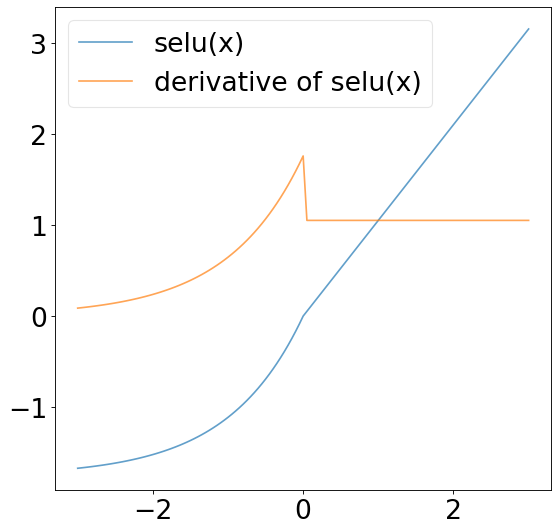

In [50]:
x = np.linspace(-3, 3, 121)

alpha = 1.6733
lamb = 1.0507

def selu(values):
    exponentials = alpha * np.ones(*values.shape) * (np.exp(values) - 1.)
    exponentials[values > 0] = values[values > 0]
    return exponentials * lamb


def Dselu(values):
    exponentials = alpha * np.ones(*values.shape) * (np.exp(values))
    exponentials[values > 0] = 1
    return exponentials * lamb

plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')


plt.plot(
    x,
    selu(x),
#     'r-',
    alpha=0.7
)

plt.plot(
    x,
    Dselu(x),
    alpha=0.7
)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.legend(['selu(x)', 'derivative of selu(x)'], prop={'size': 24}, framealpha=0.5)

plt.savefig('images/selu.png', transparent=True)

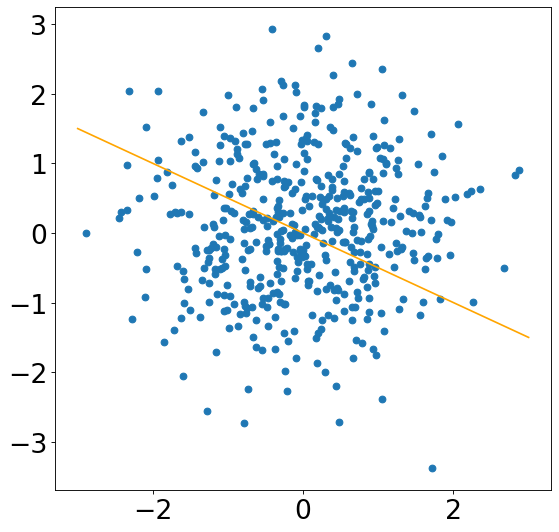

In [66]:
import random
x = np.linspace(-3, 3, 61)
two_d = [(random.gauss(0, 1), random.gauss(0, 1)) for _ in range(100)]

plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

plt.scatter([random.gauss(0, 1) for _ in range(500)], [random.gauss(0, 1) for _ in range(500)])

plt.plot(x, -.5 * x, color='orange')
plt.tick_params(axis='both', which='major', labelsize=24)


plt.savefig('images/point_cloud.png', transparent=True)

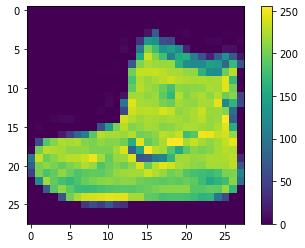

In [4]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

plt.savefig('images/selu.png', transparent=True)


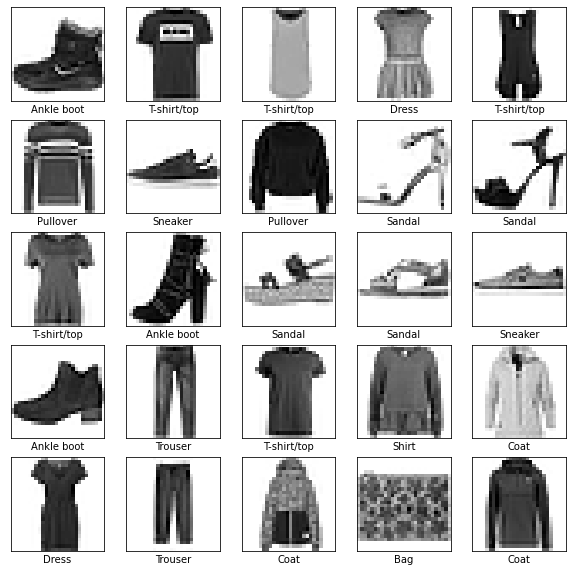

In [5]:
train_images = train_images.reshape(-1, 28, 28, 1) / 255.0
# train_images = train_images / 255.0

test_images = test_images.reshape(-1, 28, 28, 1) / 255.0

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
batch_size = 100

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
    width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
    vertical_flip=True
)

datagen.fit(train_images)

train_dataset = tf.data.Dataset.from_generator(
    lambda: datagen.flow(train_images, train_labels, batch_size=batch_size), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([batch_size, 28, 28, 1], [batch_size, ])
)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))


In [8]:
[one for one in (train_dataset.take(1))]

[(<tf.Tensor: shape=(28, 28, 1), dtype=float64, numpy=
  array([[[0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ]],
  
         [[0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
          [0.        ],
     

In [10]:


activations = [tf.keras.activations.relu, tf.keras.activations.selu]
activation = activations[1]

regularization_strength = 6e-4
learning_rate = 3e-4
dropout_rate = 0.25
batch_size = 100
factor = 1

dense_neurons = [512] * 1 + [256] * factor + [128] * factor + [64] * factor + [32] * factor

dense_layers = [
    tf.keras.layers.Dense(
        num_neurons,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.L2(regularization_strength)
    ) for num_neurons in dense_neurons
]

if activation == tf.keras.activations.relu:
    dense_layers = [
        one_element
        for layer in dense_layers
        for one_element in [layer, tf.keras.layers.BatchNormalization()]
    ]

model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(28,28,1)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    *dense_layers,
    tf.keras.layers.Dense(10)
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)



history = model.fit(
    train_dataset.batch(batch_size).prefetch(200).shuffle(2000).repeat(),
    validation_data=test_dataset.batch(batch_size).cache(),
    steps_per_epoch=600,
    epochs=30
)
# factor 2, increased regularization to 6

Epoch 1/30
600/600 [==============================] - 298s 496ms/step - loss: 1.3762 - accuracy: 0.8479 - val_loss: 1.3793 - val_accuracy: 0.8151
Epoch 2/30
 57/600 [=>............................] - ETA: 5:10 - loss: 1.1301 - accuracy: 0.8912

KeyboardInterrupt: 

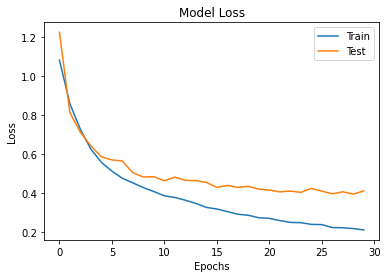

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)       